# EAA Winter School in Computational Acoustics 2018

## Finite-difference tutorial

### Preamble

We begin by loading a number of standard modules such as `numpy` and `matplotlib`. We also adjust some default parameters of figures.

In [1]:
import numpy as np
from numpy import exp, sqrt
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
mpl.rc('lines', linewidth=2)
mpl.rc('font', size=14)
mpl.rc('axes', linewidth=1.5, labelsize=14)
mpl.rc('legend', fontsize=14)

### Definition of the problem

We consider the problem of the transport equation (also known as the one-way wave equation)
$$
\frac{\partial f}{\partial t}
+ a \frac{\partial f}{\partial x}
= 0
\;,
$$
where $f(x,t)$ is the solution of the problem and $a$ is the constant convection veclocity.
This equation is solved on the domain $0<x<L$ between the initial time $t=T_\mathrm{min}$ and the final time $t=T_\mathrm{max}$.

The initial condition is of the form:
$$
f(x,t=0) = \frac{x-x_0}{w}\exp\left[ -\frac{(x-x_0)^2}{2w^2} \right]
\;,
$$
where $x_0$ is the initial position of the waveform and $w$ is the width of the waveform.

We use periodic boundary conditions between the two end points of the computational domain. In other word: $f(x=0,t)=f(x=L,t)$.

We define the physical parameters introduced so far:

In [2]:
a = 1  # Convection velocity
w = 1  # Width of the waveform
L = 20  # Length of the domain
x0 = L/2 # Initial position of the waveform
Tmin = 0  # Initial time
Tmax = 40  # Final time

We also define a function implementing the exact solution to this problem:

In [3]:
def f_exact(x, t):
    s = np.mod(x-t, L)-x0
    return(s/w*np.exp(-s**2/w**2/2))

### Numerical schemes

We use the standard 7-point, centered finite-difference scheme for the spatial derivative. The spatial derivative is approximated by the following expression
$$
f'(x) \simeq \frac{1}{\Delta x} \sum_{n=-3}^{+3} a_n f(x+n\Delta x)
\;.
$$
The coefficients are:
$$
a_{-3} = -\frac{1}{60}
\;,\quad
a_{-2} = \frac{9}{60}
\;,\quad
a_{-1} = -\frac{45}{60}
\;,\quad
a_{0} = 0
\;,\quad
a_{+1} = \frac{45}{60}
\;,\quad
a_{+2} = -\frac{9}{60}
\;,\quad
a_{+3} = \frac{1}{60}
\;.
$$
This is define as follows:

In [4]:
FD7 = np.array([-1., 9., -45., 0., 45., -9., 1.])/60

For the time integration we use the standard 4-stage Runge-Kutta scheme. Its coefficients are defined as follows:

In [5]:
RK4 = np.array([0.25, 1./3., 0.5, 1.])

### Grid

We use a uniform grid with $N$ points:

In [6]:
N = 50

We define the grid points $x_n$ and the grid spacing $\mathrm{d}x$:

In [7]:
xn = np.linspace(0, L, N)
dx = xn[1] - xn[0]

We have to extend the grid to include additional points for the periodic boundary conditions.

In [8]:
xn = np.linspace(-3*dx, L+2*dx, N+5)

### Time step

The time step is defined through the CFL number $a\Delta t/\Delta x$

In [9]:
CFL = 1.9

We calculate the time step from this value of the CFL number.
We can then calculate the number of time steps $N_t$ to reach $t=T_{max}$.

In [10]:
dt = dx*CFL/a
Nt = int(np.ceil((Tmax-Tmin)/dt)+1)
tn = np.linspace(Tmin, Tmax, Nt)
dt = tn[1] - tn[0]

### Simulation

We can now perform the numerical simulation of the solution.

We define a vector containing the initial condition:

In [11]:
f0 = np.transpose(f_exact(xn, Tmin)).reshape(len(xn),)

We can then perform the time integration

In [12]:
f = f0.copy()
t = Tmin

F = np.zeros((Nt, len(f)))
T = np.zeros((Nt, ))

# Loop over the time step
for step in range(Nt):
    # Store the current solution and time step
    F[step, :] = f
    T[step] = t
    fn = f.copy()
    for stage in range(len(RK4)):
        # Calculate the spatial derivative of the solution
        dfdx = -np.convolve(f, FD7, 'same')/dx
        # Calculate the time derivative of the solution
        dfdt = -a*dfdx
        # Update the solution using the Runge-Kutta time marching scheme
        f = fn + RK4[stage]*dt*dfdt
        # Implement the periodic boundary condition
        f[:3] = f[-6:-3].copy()
        f[-3:] = f[3:6].copy()
    t += dt

### Numerical error

We can calculate a relative error between the numerical solution and the exact solution. For this we calculate the difference between the two solutions at each grid points at the last time step:

In [13]:
df = F[-1,:] - f_exact(xn, T[-1])
relative_error = np.sqrt(np.sum(df**2)/np.sum(f_exact(xn, T[-1])**2))

We can output the relative error in percent:

In [14]:
print(relative_error*100)

2902323.402687334


### Visualisation

We can generate an animation of the solution as follows:

<IPython.core.display.Javascript object>


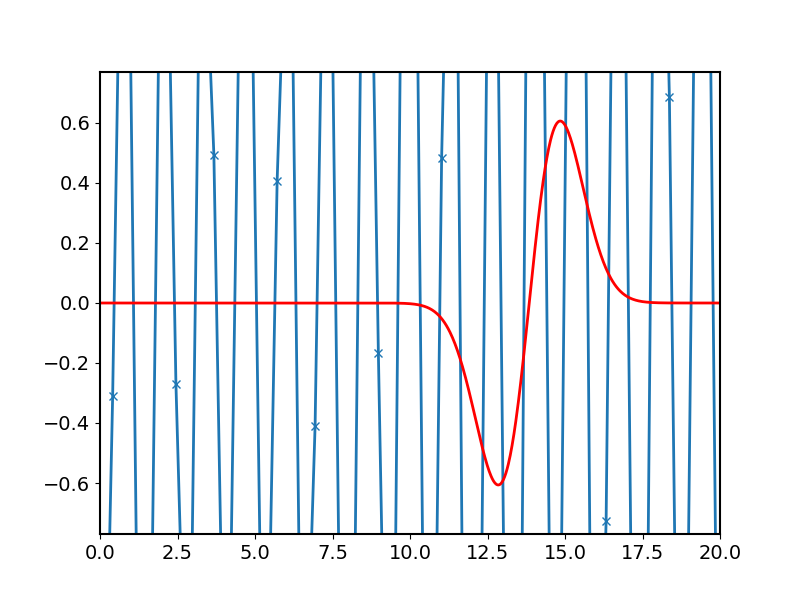

In [15]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
l, = ax.plot([0,L],[-0.7,0.7], '-x')
l2, = ax.plot([0,L],[-0.7,0.7], 'r-')
plt.xlim(0, L)

xx = np.linspace(0, L, 1000)

def animate(i):
    l.set_data(xn, F[i,:])
    l2.set_data(xx, f_exact(xx, T[i]))
    

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=Nt)

### Question 1: Application of the spatial derivative

**a.** Consider the function $f(x)=\sin(x)$. Calculate the exact value of $f'$ at $x=1$.

**b.** Use the finite difference relation with the 7-point stencil `FD7` to estimate this derivative using $\Delta x=0.01$. Compare with the exact value.

### Question 2: Order of convergence

**a.** What is the order of the derivative scheme defined by the coefficients in `FD7`?

**b.** What is the order of the integration scheme defined by the coefficients in `RK4`?

**c.** Multiply the number of points $N$ by 2, and then by 4, and note the relative error in each case. Can you estimate the rate of convergence of the numerical model?

**d.** With $N=50$, divide the CFL number by 2, and then by 4, and note the relative error in each case. Is the numerical error dominated by the spatial resolution or the temporal resolution?

### Question 3: Stability

**a.** Using $N=100$, run the simulation with a CFL number of 1.0, 1.8 and 1.9. For which of these values is the solution stable? For which of these values is the solution accurate?

### Question 4: An improved derivative scheme

**a.** Instead of the coefficients `FD7` defined above use the following optimized DRP scheme (the coefficients are taken from the book *Computational aero-acoustics* by C.K.W. Tam)

In [16]:
FD7 = np.array([-0.0208431427, 0.1667059044, -0.770882380, 0, 0.770882380, -0.1667059044, 0.0208431427])

**b.** Compare the accuracy of this scheme with the standard scheme.

### Question 5: Filtering (optional)

We would like to add a selective filter applied to the solution at each time step. We use a 7-point filter with the following coefficients:

In [17]:
SF7 = np.array([-0.0219899680, 0.1043103128, -0.2280100319, +0.2913793743, -0.2280100319, 0.1043103128, -0.0219899680])

These coefficients are used in the following formula defining the filtered solution:
$$
\tilde{f}(x) = f(x) - \sigma \sum_{n=-3}^{+3} b_n f(x+n\Delta x)
\;,
$$
where $\tilde{f}$ is the filtered solution. The parameter $\sigma$ allows to adjust the strength of the filter.

**a.** Define the variable `sigma`:

In [18]:
sigma = 1

**b.** Modify the code to add the application of the filter at each time step. Add the following lines of code after `t += dt` in the loop over the time steps:

In [19]:
    # Apply the filter
    f -= sigma * np.convolve(f, SF7, 'same')
    # Implement the periodic boundary condition
    f[:3] = f[-6:-3].copy()
    f[-3:] = f[3:6].copy()

**c.** Run the simulation for $N=50$ and a CFL of 1.9. What difference do you observe compared to the case without filtering?